[*********************100%***********************]  1 of 1 completed

Samples: total=3858 | train=3087 | test=771

=== CV 1 (Price metrics) ===
MAE (₹) : 2.0658
R²      : 0.9648

=== CV 2 (Price metrics) ===
MAE (₹) : 2.5118
R²      : 0.9484

=== CV 3 (Price metrics) ===
MAE (₹) : 3.5933
R²      : 0.9963

=== CV 4 (Price metrics) ===
MAE (₹) : 9.6215
R²      : 0.9854

=== CV 5 (Price metrics) ===
MAE (₹) : 13.4807
R²      : 0.9750

CV Price MAE (mean ± std): 6.2546 ± 4.5208

--- Baseline (predict 0% return) ---

=== Baseline (Price metrics) ===
MAE (₹) : 12.1149
R²      : 0.9861

--- RidgeCV (return model) ---

=== Test (Price metrics) ===
MAE (₹) : 12.1032
R²      : 0.9861

📄 Saved test predictions: test_predictions_prices.csv

================ NEXT TRADING DAY FORECAST ================
Ticker          : RELIANCE.NS
Last trading    : 2025-10-30  (Close_t = 1,488.50)
Pred log-ret    : +0.00050  (~+0.05%)
Pred Close (t+1): 1,489.24


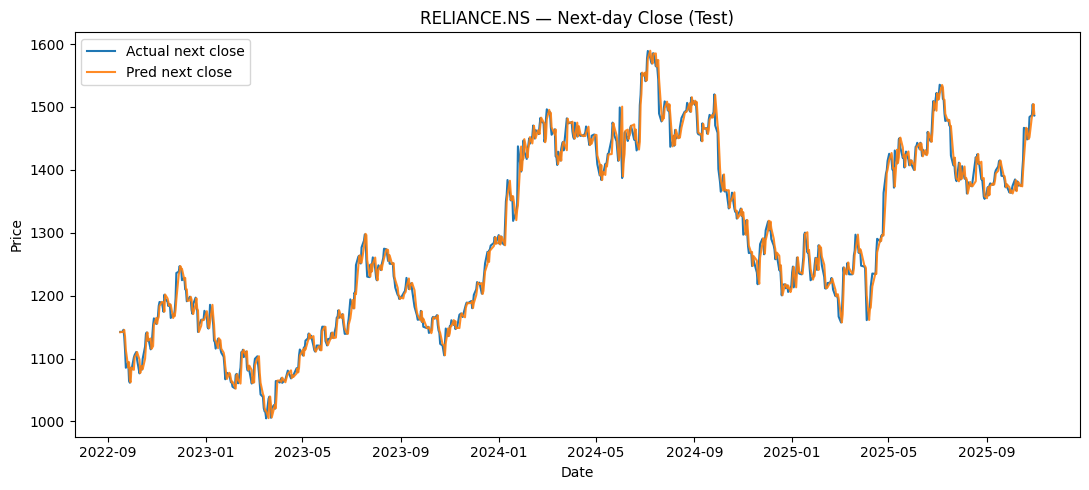


✅ Saved model: ridge_nextday_return.pkl


In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Next-day Close Prediction via RETURN (RidgeCV, leak-safe, version-safe)
======================================================================

- Uses Yahoo *adjusted* OHLCV (auto_adjust=True) to avoid split/div shocks
- Predicts next-day *log return* r_{t+1} = log(C_{t+1}/C_t) (stationary)
- Reconstructs price: Ĉ_{t+1} = C_t * exp(r̂_{t+1})
- Regularization: RidgeCV with log-spaced alphas (no version-specific kwargs)
- Clips extreme predicted returns (±k·σ_train)
- Walk-forward CV on TRAIN; baseline = 0% return (tomorrow ≈ today)
- Exports detailed test predictions; prints next trading day forecast

Run:
    pip install yfinance pandas numpy scikit-learn matplotlib joblib
    python nextday_return_ridge.py
"""

# -----------------------
# Config (edit here)
# -----------------------
TICKER      = "RELIANCE.NS"
START_DATE  = "2010-01-01"
END_DATE    = "2025-11-02"          # None => up to today
TEST_SIZE   = 0.20          # last 20% as holdout
N_SPLITS    = 5             # walk-forward splits on TRAIN
SAVE_MODEL  = True
MODEL_PATH  = "ridge_nextday_return.pkl"
PLOT        = True
EXPORT_CSV  = True
CSV_PATH    = "test_predictions_prices.csv"
CLIP_SIGMAS = 4.0           # clip predicted returns to +/- this many train-σ

# -----------------------
# Imports
# -----------------------
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# -----------------------
# Feature engineering
# -----------------------
def rsi_wilder(close: pd.Series, period: int = 14) -> pd.Series:
    d = close.diff()
    gain = d.clip(lower=0)
    loss = -d.clip(upper=0)
    ag = gain.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    al = loss.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    rs = ag / al.replace(0, np.nan)
    rsi = 100 - 100/(1+rs)
    return rsi.fillna(50.0)

FEATURES = [
    "ret1","ret3","ret5","ret10","ret20",
    "vol5","vol10","vol20",
    "rsi14",
    "vol_z20",
    "hl_range_pct","oc_range_pct",
    "ma5_dev","ma10_dev","ma20_dev","ma50_dev",
]

def make_feature_frame(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # returns
    out["ret1"]  = out["Close"].pct_change(1)
    out["ret3"]  = out["Close"].pct_change(3)
    out["ret5"]  = out["Close"].pct_change(5)
    out["ret10"] = out["Close"].pct_change(10)
    out["ret20"] = out["Close"].pct_change(20)

    # realized vol (std of daily returns)
    out["vol5"]  = out["ret1"].rolling(5).std()
    out["vol10"] = out["ret1"].rolling(10).std()
    out["vol20"] = out["ret1"].rolling(20).std()

    # RSI (on Close)
    out["rsi14"] = rsi_wilder(out["Close"], 14)

    # intraday structure
    out["hl_range_pct"] = (out["High"] - out["Low"]) / out["Close"]
    out["oc_range_pct"] = (out["Close"] - out["Open"]) / out["Close"]

    # volume z-score
    vol_ma = out["Volume"].rolling(20).mean()
    vol_sd = out["Volume"].rolling(20).std()
    out["vol_z20"] = (out["Volume"] - vol_ma) / vol_sd

    # moving average deviations (relative to price)
    for w in (5,10,20,50):
        ma = out["Close"].rolling(w).mean()
        out[f"ma{w}_dev"] = (out["Close"] / ma) - 1.0

    # target: NEXT-DAY *log* return
    out["y_logret_next"] = np.log(out["Close"].shift(-1) / out["Close"])

    out = out.dropna().copy()
    return out

def time_split(df: pd.DataFrame, test_size: float):
    n = len(df)
    n_test = int(np.floor(n * test_size))
    return df.iloc[:n-n_test].copy(), df.iloc[n-n_test:].copy()

# -----------------------
# Eval helpers
# -----------------------
def eval_price_metrics(close_t, y_true_logret, y_pred_logret, label="Test"):
    """
    Convert predicted/true log-returns to prices and compute MAE/R2 on prices.
    y_true_logret / y_pred_logret aligned on same index; close_t is today's Close (t).
    """
    actual_next = close_t * np.exp(y_true_logret)
    pred_next   = close_t * np.exp(y_pred_logret)

    mae_price = mean_absolute_error(actual_next, pred_next)
    r2_price  = r2_score(actual_next, pred_next)

    print(f"\n=== {label} (Price metrics) ===")
    print(f"MAE (₹) : {mae_price:,.4f}")
    print(f"R²      : {r2_price:,.4f}")
    return actual_next, pred_next, {"MAE_price": mae_price, "R2_price": r2_price}

# -----------------------
# Main
# -----------------------
def main():
    print(f"Downloading {TICKER} (adjusted OHLCV)...")
    df = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=True, multi_level_index=False)
     # auto_adjust=True gives adjusted OHLCV (split/dividend adjusted)
    if df.empty:
        raise ValueError("No data. Check ticker/dates/network.")
    df = df[["Open","High","Low","Close","Volume"]].copy()

    data = make_feature_frame(df)
    X = data[FEATURES].copy()
    y = data["y_logret_next"].copy()
    close_t_all = df.loc[X.index, "Close"]

    # split
    X_tr, X_te = time_split(X, TEST_SIZE)
    y_tr, y_te = time_split(y.to_frame(), TEST_SIZE)
    y_tr, y_te = y_tr.squeeze(), y_te.squeeze()
    close_t_tr, close_t_te = time_split(close_t_all.to_frame(), TEST_SIZE)
    close_t_tr, close_t_te = close_t_tr.squeeze(), close_t_te.squeeze()

    print(f"Samples: total={len(X)} | train={len(X_tr)} | test={len(X_te)}")

    # walk-forward CV on TRAIN
    alphas = np.logspace(-6, 3, 30)     # robust grid
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    cv_mae = []
    for i, (idx_tr, idx_val) in enumerate(tscv.split(X_tr), 1):
        X_tr_i, X_val_i = X_tr.iloc[idx_tr], X_tr.iloc[idx_val]
        y_tr_i, y_val_i = y_tr.iloc[idx_tr], y_tr.iloc[idx_val]
        c_val_i = close_t_tr.iloc[idx_val]

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", RidgeCV(alphas=alphas))  # version-safe: no extra kwargs
        ])
        pipe.fit(X_tr_i, y_tr_i)
        y_val_hat = pipe.predict(X_val_i)

        # clip extreme predicted log-returns to +/- k * σ_train
        sigma = y_tr_i.std()
        y_val_hat = np.clip(y_val_hat, -CLIP_SIGMAS*sigma, CLIP_SIGMAS*sigma)

        # report MAE in *price* space
        _, _, m = eval_price_metrics(c_val_i.values, y_val_i.values, y_val_hat, label=f"CV {i}")
        cv_mae.append(m["MAE_price"])

    if cv_mae:
        print(f"\nCV Price MAE (mean ± std): {np.mean(cv_mae):.4f} ± {np.std(cv_mae):.4f}")

    # fit on all TRAIN
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", RidgeCV(alphas=alphas))
    ])
    model.fit(X_tr, y_tr)

    # TEST predict (log-return), clip, evaluate in price space
    y_hat_te = model.predict(X_te)
    sigma_tr = y_tr.std()
    y_hat_te = np.clip(y_hat_te, -CLIP_SIGMAS*sigma_tr, CLIP_SIGMAS*sigma_tr)

    # Baseline: 0% return => next price = today's close
    baseline_logret = np.zeros_like(y_te.values)

    print("\n--- Baseline (predict 0% return) ---")
    _ = eval_price_metrics(close_t_te.values, y_te.values, baseline_logret, label="Baseline")

    print("\n--- RidgeCV (return model) ---")
    actual_next, pred_next, _ = eval_price_metrics(close_t_te.values, y_te.values, y_hat_te, label="Test")

    # export
    if EXPORT_CSV:
        out = pd.DataFrame({
            "date": X_te.index,
            "close_t": close_t_te.values,
            "actual_next_close": actual_next,
            "pred_next_close": pred_next,
            "pred_logret": y_hat_te,
            "actual_logret": y_te.values,
        }).set_index("date")
        out["residual"] = out["actual_next_close"] - out["pred_next_close"]
        out.to_csv(CSV_PATH, float_format="%.6f")
        print(f"\n📄 Saved test predictions: {CSV_PATH}")

    # next trading day forecast
    f_all = make_feature_frame(df)  # has aligned features; we only need X
    X_last = f_all[FEATURES].iloc[[-1]]
    last_date = f_all.index[-1]
    close_last = df.loc[last_date, "Close"]
    rhat_next = np.clip(model.predict(X_last)[0], -CLIP_SIGMAS*sigma_tr, CLIP_SIGMAS*sigma_tr)
    pred_next_price = close_last * np.exp(rhat_next)

    print("\n================ NEXT TRADING DAY FORECAST ================")
    print(f"Ticker          : {TICKER}")
    print(f"Last trading    : {pd.Timestamp(last_date).date()}  (Close_t = {close_last:,.2f})")
    print(f"Pred log-ret    : {rhat_next:+.5f}  (~{(np.exp(rhat_next)-1)*100:+.2f}%)")
    print(f"Pred Close (t+1): {pred_next_price:,.2f}")
    print("===========================================================")

    if PLOT:
        plt.figure(figsize=(11,5))
        plt.plot(X_te.index, actual_next, label="Actual next close")
        plt.plot(X_te.index, pred_next,   label="Pred next close", alpha=0.9)
        plt.title(f"{TICKER} — Next-day Close (Test)")
        plt.xlabel("Date"); plt.ylabel("Price")
        plt.legend(); plt.tight_layout(); plt.show()

    if SAVE_MODEL:
        joblib.dump(model, MODEL_PATH)
        print(f"\n✅ Saved model: {MODEL_PATH}")

if __name__ == "__main__":
    main()
